In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

import scipy.signal as signal

# Set rcParams to customize tick labels and spines
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.grid'] = True
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['legend.loc'] = 'upper right'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams["figure.autolayout"] = True


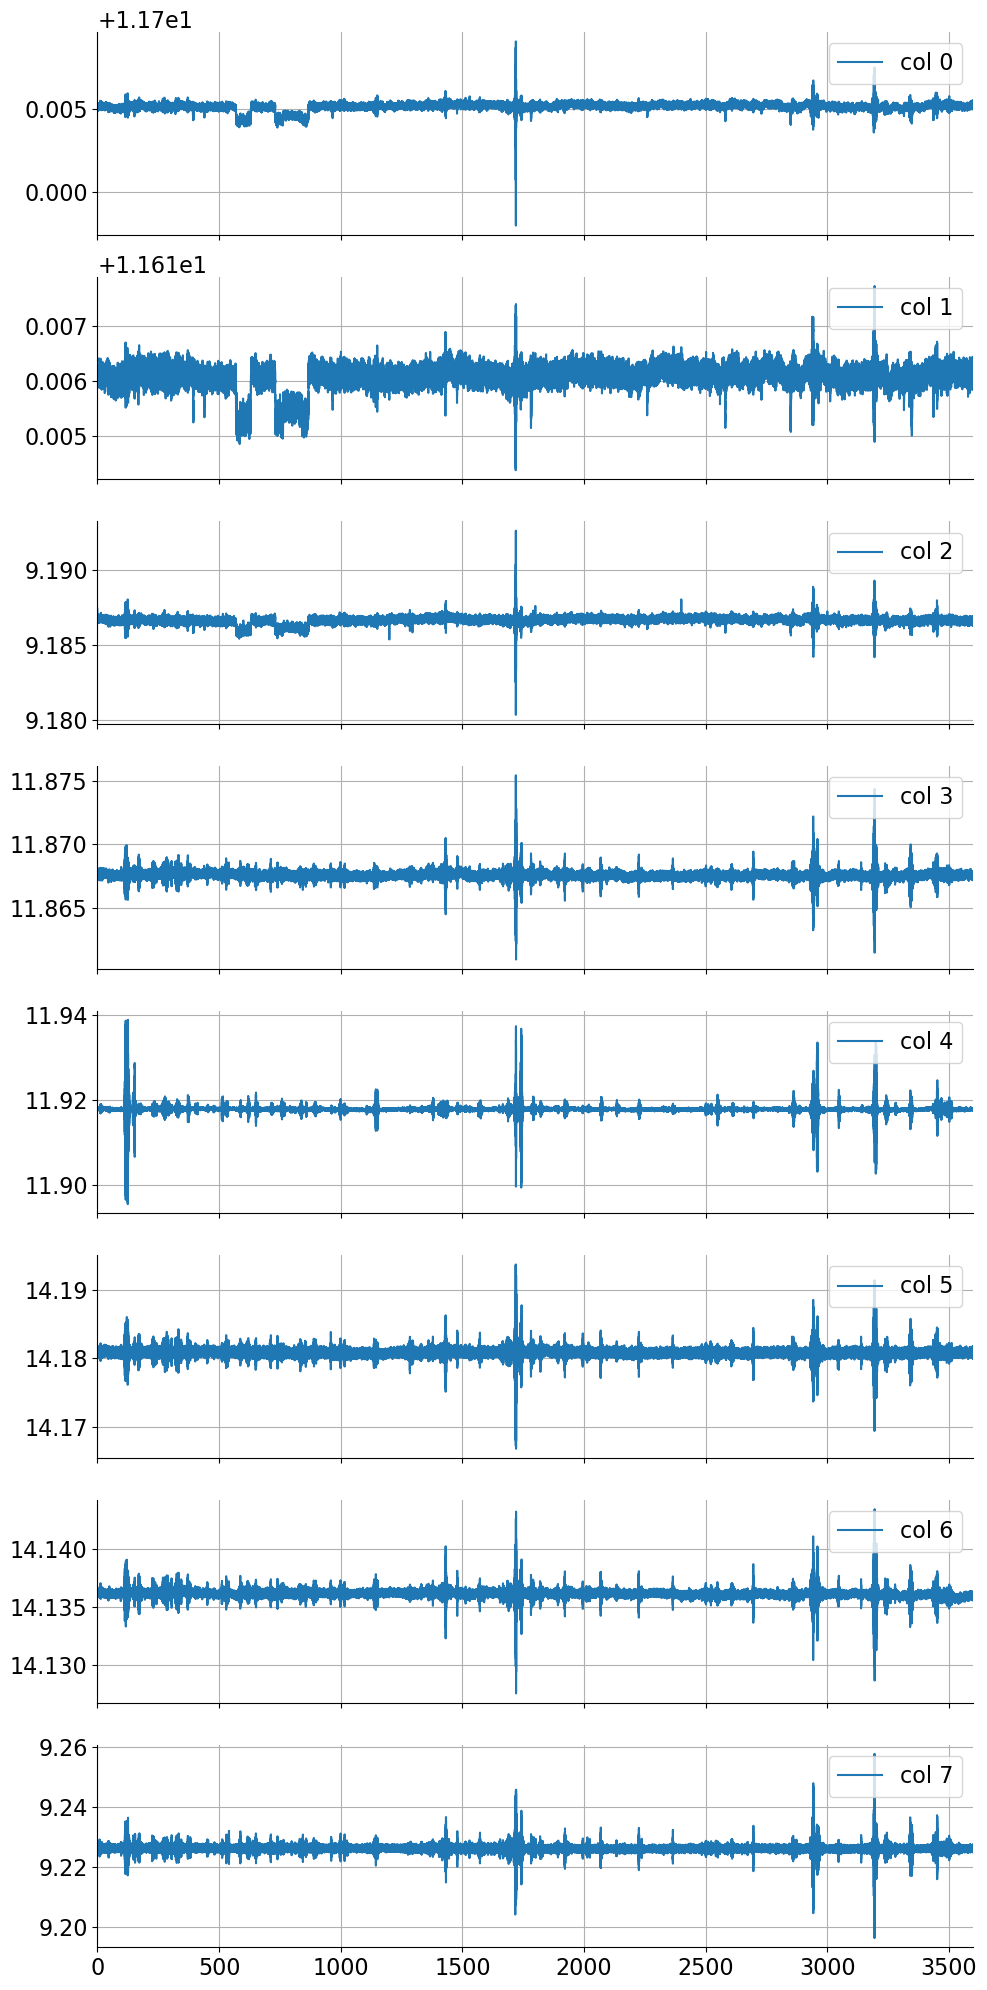

In [3]:
# Load the datas
data_23_01 = np.loadtxt("Lello/Jul23/data_2023_07_10_040019_0.csv", delimiter=";")
data_23_02 = np.loadtxt("Lello/Jul23/data_2023_07_10_041032_0.csv", delimiter=";")
data_23_03 = np.loadtxt("Lello/Jul23/data_2023_07_10_042045_0.csv", delimiter=";")
data_23_04 = np.loadtxt("Lello/Jul23/data_2023_07_10_043058_0.csv", delimiter=";")
data_23_05 = np.loadtxt("Lello/Jul23/data_2023_07_10_044111_0.csv", delimiter=";")
data_23_06 = np.loadtxt("Lello/Jul23/data_2023_07_10_045123_0.csv", delimiter=";")



# Extract time and sensor data
sensor_data = np.concatenate([data_23_01[:, 1:], data_23_02[:, 1:], data_23_03[:, 1:], data_23_04[:, 1:], data_23_05[:, 1:], data_23_06[:, 1:]])
time = np.linspace(0, 600*6, len(sensor_data))

# Plot the datas
fig, ax = plt.subplots(len(sensor_data[0]), 1, sharex=True, figsize=(10, 20))
for i in range(8):
    ax[i].plot(time, sensor_data[:, i], label=f"col {i}")
    ax[i].legend()
    ax[i].set_xlim(0, 3600)
plt.show()


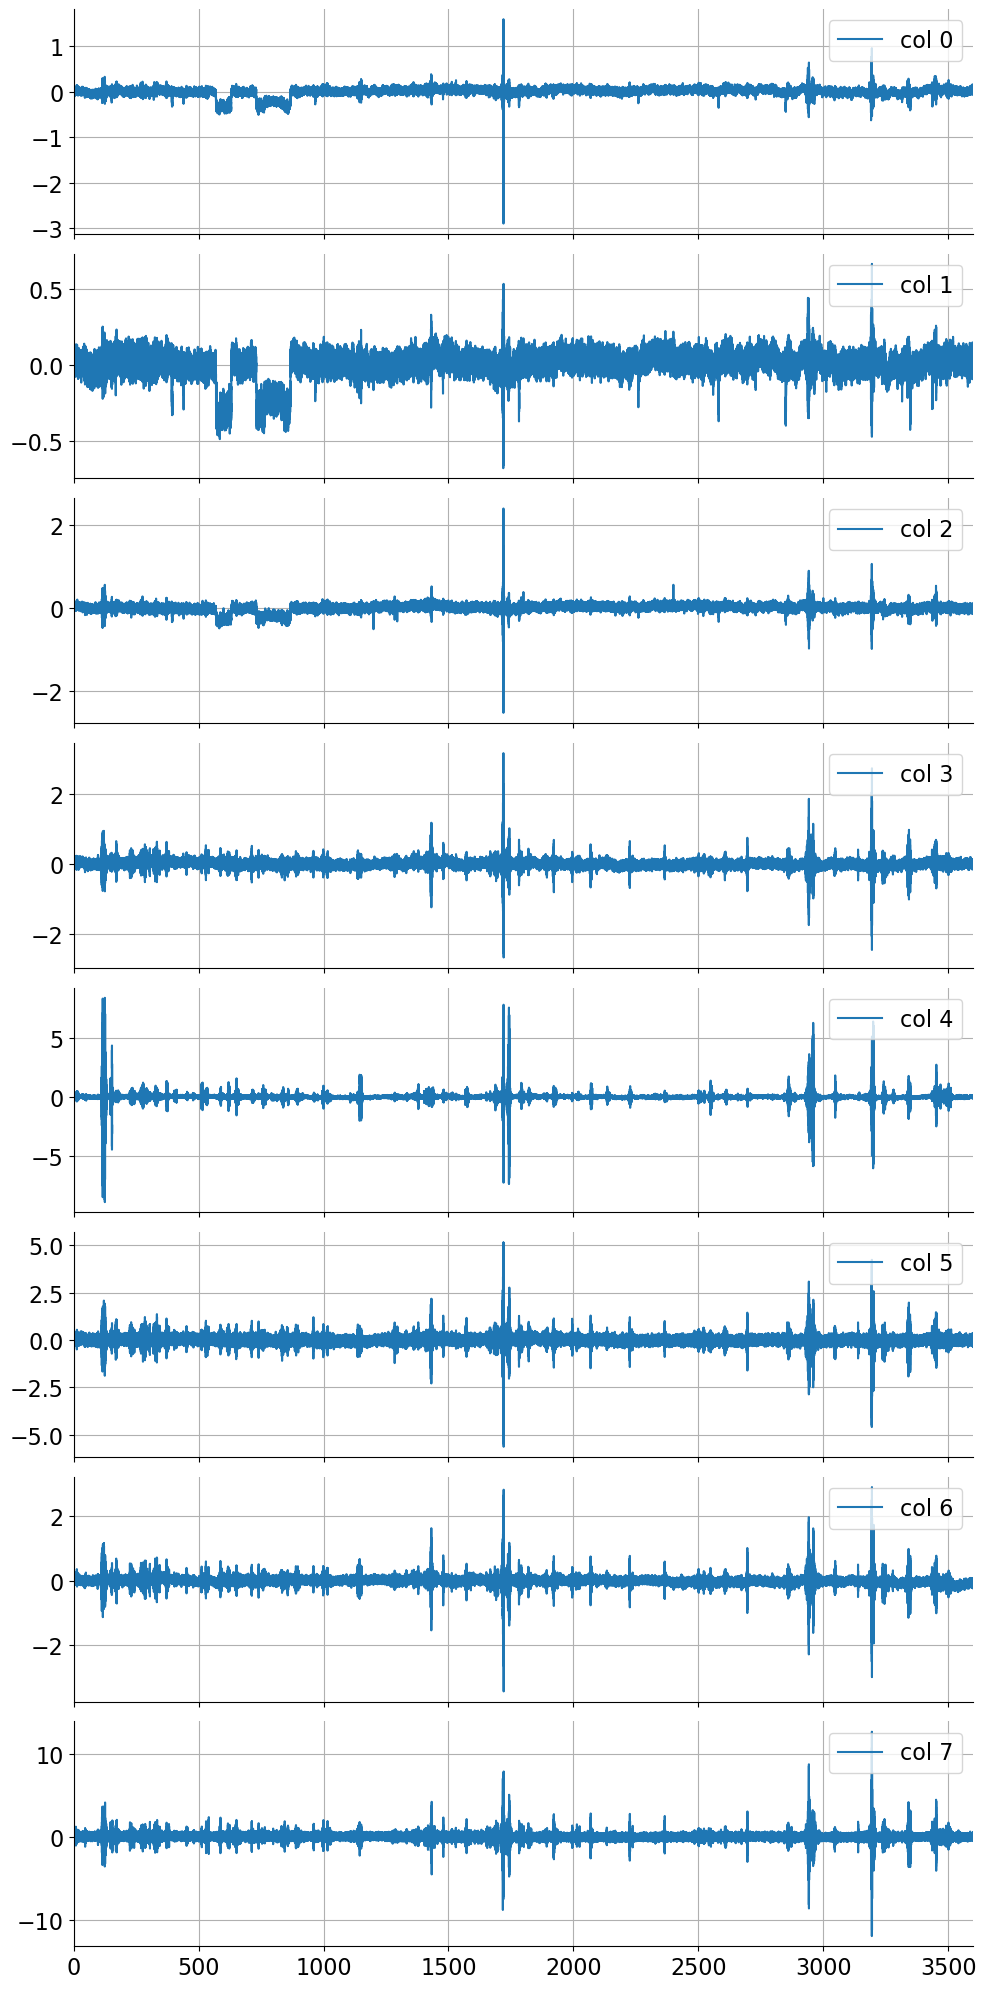

In [4]:
# Parameters
n_samples, n_sensors = sensor_data.shape

# Get the Discrete Fourier Transform (DFT) sample frequencies
sampling_dt = np.mean(np.diff(time)) # s
frequencies = np.fft.rfftfreq(n_samples, d=sampling_dt)

# Subtract the mean to remove the DC component
sensor_data_detrended = sensor_data - np.mean(sensor_data, axis=0)

# Scale the data, convert electrical signal (ampers) to "10-3 g" (i.e., mg)
factors = np.array([0.4035*1000, 0.4023*1000, 0.4023*1000, 0.4023*1000, 0.4015*1000, 0.4014*1000, 0.4007*1000, 0.4016*1000])
sensor_data_detrended = sensor_data_detrended * factors

# Plot the scaled datas without the DC component
fig, ax = plt.subplots(len(sensor_data_detrended[0]), 1, sharex=True, figsize=(10, 20))
for i in range(8):
    ax[i].plot(time, sensor_data_detrended[:, i], label=f"col {i}")
    ax[i].legend()
    ax[i].set_xlim(0, 3600)
plt.show()

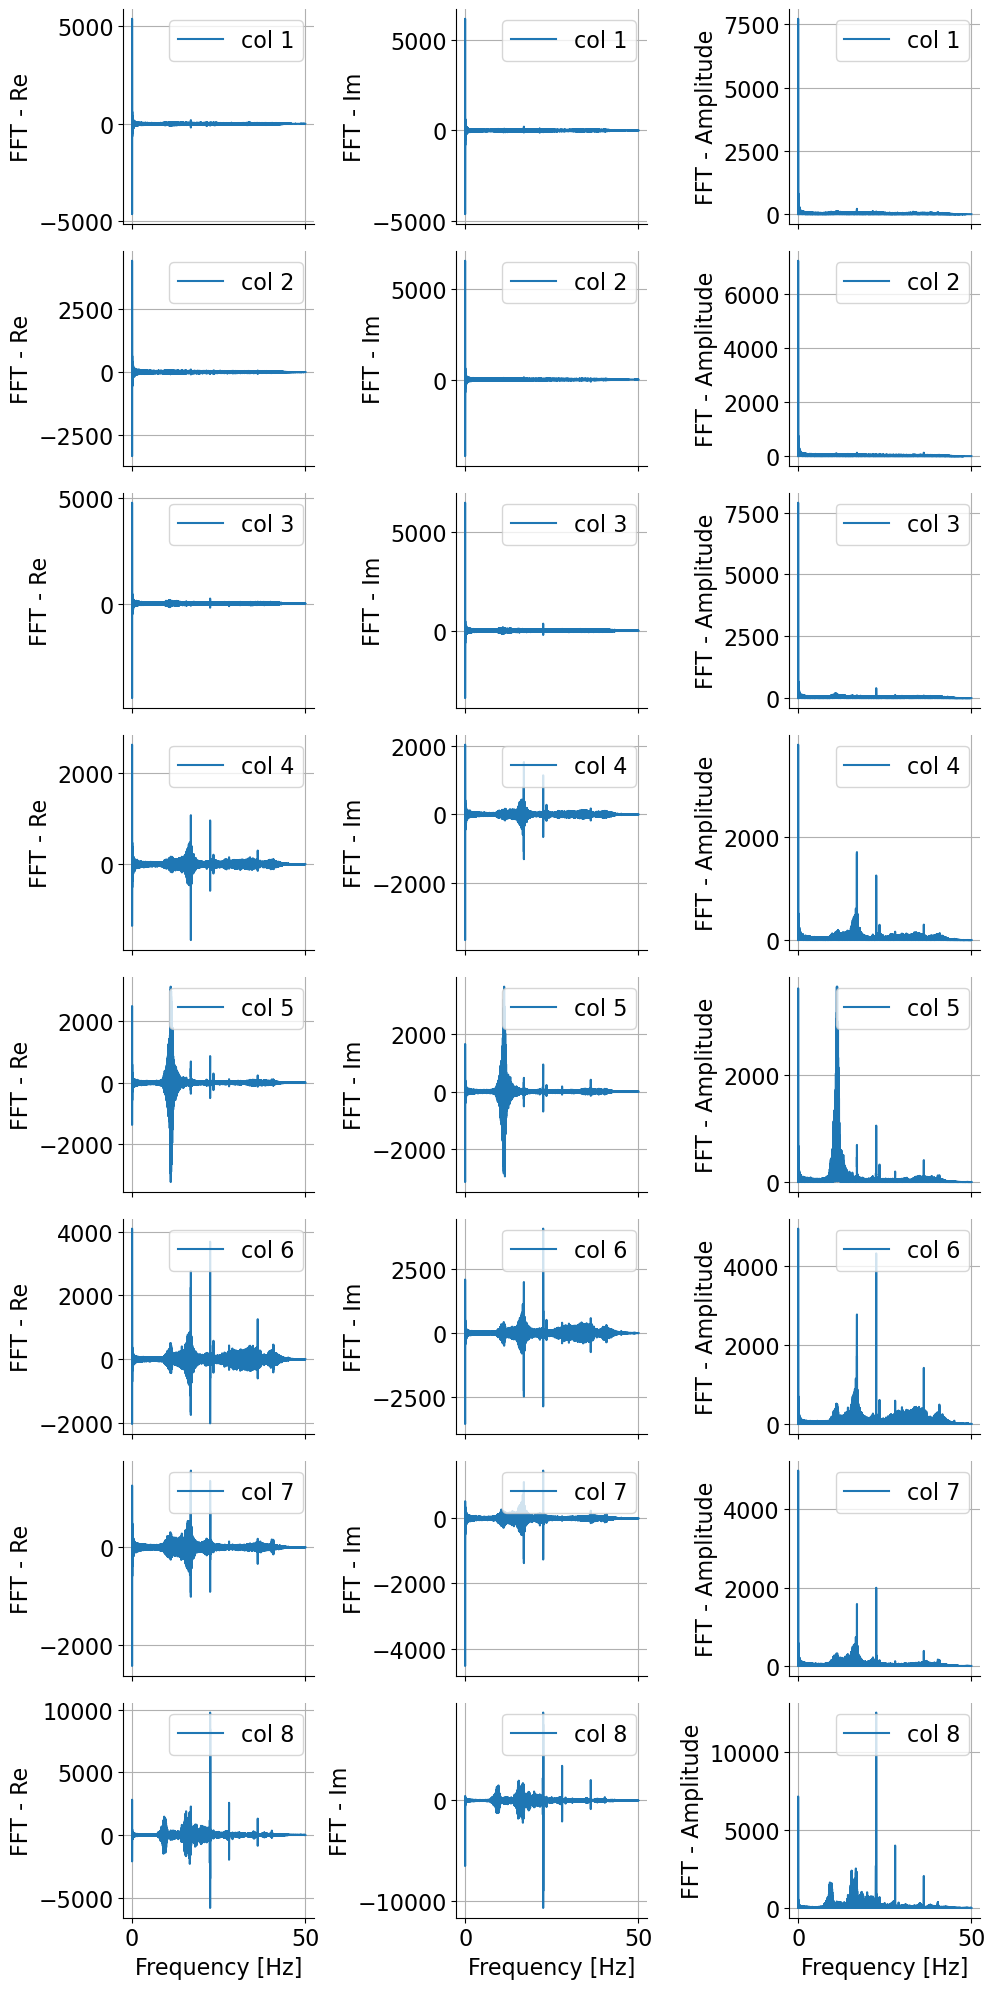

In [5]:
# Convert to frequency domain by FFT
data_fft = np.fft.rfft(sensor_data_detrended, axis=0)

# Plot the FFT
fig, ax = plt.subplots(len(sensor_data_detrended[0]), 3, sharex=True, figsize=(10, 20))
for i in range(8):
    ax[i, 0].plot(frequencies[:], np.real(data_fft[:, i]), label=f"col {i+1}")
    ax[i, 0].legend()
    ax[i, 0].set_ylabel("FFT - Re")
    ax[i, 1].plot(frequencies[:], np.imag(data_fft[:, i]), label=f"col {i+1}")
    ax[i, 1].legend()
    ax[i, 1].set_ylabel("FFT - Im")
    ax[i, 2].plot(frequencies[:], np.abs(data_fft[:, i]), label=f"col {i+1}")
    ax[i, 2].legend()
    ax[i, 2].set_ylabel("FFT - Amplitude")
ax[-1, 0].set_xlabel("Frequency [Hz]")
ax[-1, 1].set_xlabel("Frequency [Hz]")
ax[-1, 2].set_xlabel("Frequency [Hz]")
plt.show()

(8, 2049)


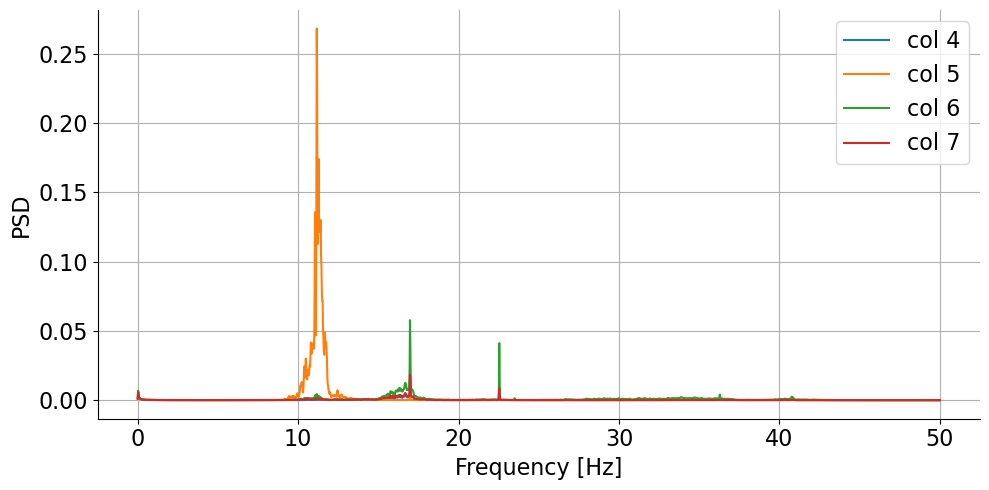

(2049, 4, 4)


In [6]:
# Compute the PSD using Welch's method for each sensor
psds = []
for sensor_signal in sensor_data_detrended.T:
    frequencies, psd = signal.welch(sensor_signal, fs=1/(time[1]-time[0]), nperseg=4096)
    psds.append(psd)

psds = np.array(psds)
print(psds.shape)

# Selecting the specific sensors
selected_sensors = psds[3:7, :]

# Plot the PSDs
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for i in range(4):
    ax.plot(frequencies, selected_sensors[i], label=f"col {i+4}")
    ax.legend()
    ax.set_xlabel("Frequency [Hz]")
    ax.set_ylabel("PSD")
plt.show()

# Initialize the PSD matrix
psd_matrix = np.zeros((len(frequencies), 4, 4), dtype=complex)

# Compute the PSD matrix
for i in range(len(frequencies)):
    psd_matrix[i] = np.outer(selected_sensors[:, i], np.conjugate(selected_sensors[:, i])) / 4



# psd_matrix = np.zeros((len(frequencies), 4, 4), dtype=complex)
# for i in range(len(frequencies)):
#     psd_matrix[i] = np.outer(data_fft[i, 3:7], np.conjugate(data_fft[i, 3:7])) / 4 # 3:7 to only consider sensors on the staircase
print(psd_matrix.shape)

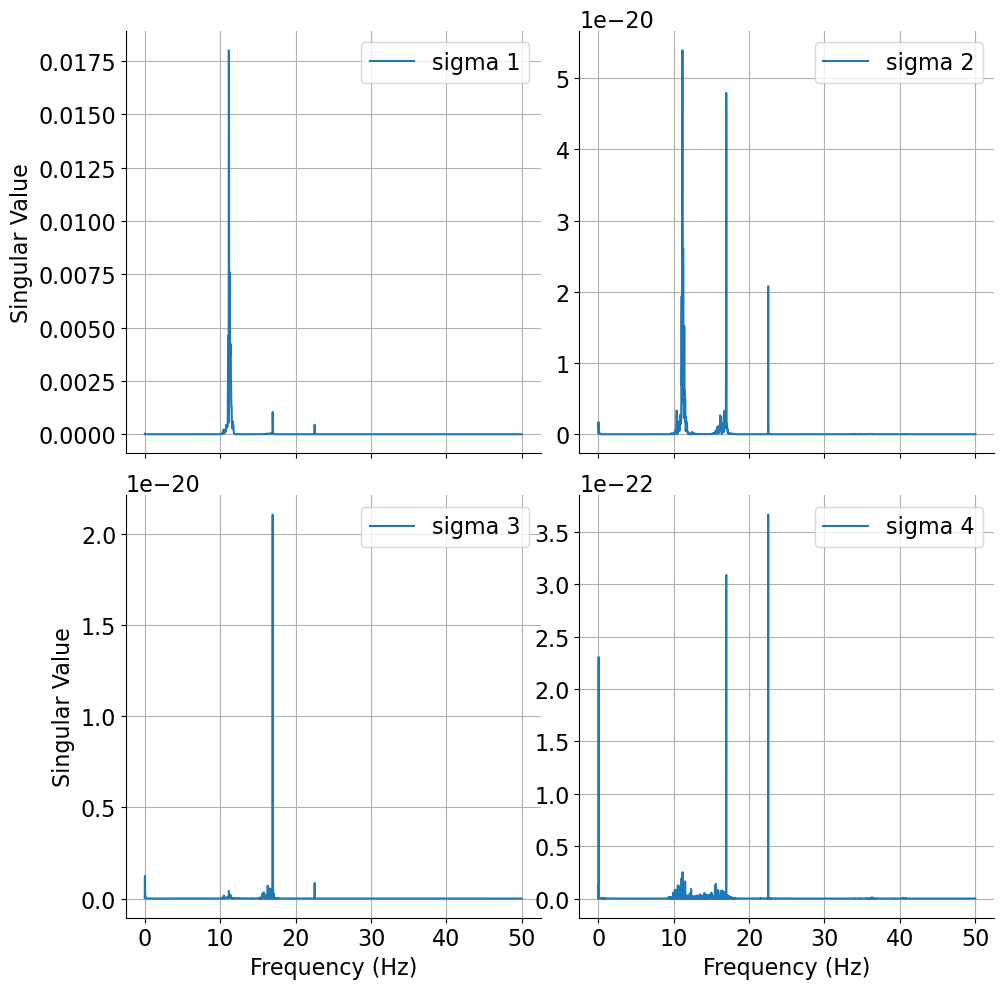

In [7]:
# Perform Singular Value Decomposition (SVD) on the PSD matrix
U, S, V = np.linalg.svd(psd_matrix, full_matrices=False)

# Plotting the singular values
if len(S[0]) != 4 : print("ERROR")
fig, ax = plt.subplots(2, 2, sharex=True, figsize=(10, 10))
for i in range(4):
    ax[i//2, i%2].plot(frequencies, S[:, i], label=f'sigma {i+1}')
    if i%2 == 0: ax[i//2, i%2].set_ylabel('Singular Value')
    ax[i//2, i%2].legend()
    # ax[i//2, i%2].set_xlim(10, 25)
ax[-1, 0].set_xlabel('Frequency (Hz)')
ax[-1, 1].set_xlabel('Frequency (Hz)')

plt.show()
# save fig to a file named "SVD_sigma_stair.pdf"
fig.savefig("SVD_sigma_stair" + "_60'" + ".pdf", format='pdf', bbox_inches='tight')

In [8]:
# Peak picking
singular_value_peaks = np.argmax(S, axis=0) # MODIFY TO TAKE INTO ACCOUNT AVERAGE SINGULAR VALUE

# Extract mode shapes (using the significant singular value's corresponding singular vector)
# mode_shapes = U[singular_value_peaks, :, 0]

# Example of identifying a specific mode
mode_frequency = frequencies[singular_value_peaks[0]]
print(f"Identified mode frequency: {mode_frequency} Hz")

Identified mode frequency: 11.157195570203992 Hz
